In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
#
from scipy import stats
#
import matplotlib.pyplot as plt
import os
from matplotlib import ticker
import tikzplotlib

## Setup

In [8]:
n = 10
m = 5
prec = 4
results_filename = "results_rw.json" #"results_rw_n15_m10.json" #"results_rw.json n=10, m=5; n=15, m=5"

In [9]:
with open('models/metadata.json', 'r') as file:
    metadata = json.load(file)
with open(os.path.join('optimization', results_filename), 'r') as file:
    results = json.load(file)
#
print("n\tm\ttrials\tbudget")
for (n_i, m_i) in set([(r['n'], r['m']) for r in results]):
    results_i = [r for r in results if r['n']==n_i and r['m']==m_i]
    trials = len(results_i)
    ng_method_i = [key for key in results_i[0].keys() if key!='ANN' and key!='n' and key!='m' and key!='k'][0]
    budget_i = results_i[0][ng_method_i]['budget']
    print(f"{n_i}\t{m_i}\t{trials}\t{budget_i}")
#
results = [r for r in results if r['n']==n and r['m']==m]
#
ng_methods = [name for name in results[0] if name not in ['n','m','k','ann']]
methods = ['SLSQP'] + ng_methods
#
for result in results:
    result['SLSQP'] = result.pop('ann')
#
losses_dict = {method: [result[method]['loss'] for result in results] for method in methods}
times_dict = {method: [result[method]['time'] for result in results] for method in methods}
deviations_dict = {method: [np.sum(result[method]['x_min'])-5*m for result in results] for method in methods}
x_min_dict = {method: [result[method]['x_min'] for result in results] for method in methods}
print(deviations_dict)

n	m	trials	budget
15	10	33	200
15	5	35	200
10	5	35	200
{'SLSQP': [0.0, -0.0026318056969287795, -3.552713678800501e-15, -3.992530437813002e-06, 0.0, -0.0003308325715920546, -1.1852207347118338e-05, -1.2103476599634178e-05, -6.064382986892269e-07, 0.0, 0.0, -0.0001837334264038759, -3.552713678800501e-15, -4.2093237340168344e-07, 1.6342482922482304e-13, 0.0, 3.0466800993167453e-07, 3.90391011606539e-06, -6.3092656194641e-05, 0.0, -0.00010589225903601118, -7.489154878470572e-06, -3.0962135394219104e-05, 0.0, 3.552713678800501e-15, -0.00039258569917066666, 0.0, 0.0, 1.1044132488535752e-05, -3.552713678800501e-15, 0.0, 0.0, -3.552713678800501e-15, -0.0011386992849864441, 2.972418361224527e-06], 'NGOpt': [0.0666884246136128, 0.08028338270129609, 0.21520239709583322, 0.09362447215603709, 0.22284224862482915, 0.18054501545214663, 0.11444533189638406, 0.17465049457809556, 0.14473723791454063, 0.2045241390646808, 0.09008336086465363, 0.21271553342840122, 0.24858890948122792, 0.1307354978133013, 0

## Basic results

In [10]:
print(f"\nResults for n={n}, m={m}\n\n" + "".join(42*["-"]) + "\n")
print(f"R^2 scores for n={n}:")
print("ANN:", round(metadata[f"{n}"]['ANN_R2'],prec))
print("XGB:", round(metadata[f"{n}"]['XGB_R2'],prec))
#
print("\nNumber of trials:", len(results))
#
print("\nMean losses:")
for method in methods:
    print(f"{round(np.mean(losses_dict[method]),prec)}: {method}")
#
print("\nMean processing times:")
for method in methods:
    print(f"{round(np.mean(times_dict[method]),prec)}: {method}")
#
print("\nMean deviations from constraint:")
for method in methods:
    deviations = [np.abs(np.sum(x_min)-5*m) for x_min in x_min_dict[method]]
    mean_deviation = np.mean(deviations)
    print(f"{round(100*mean_deviation/(5*m),prec)}%: {method}")
#
print("\nOut-of-bounds errors:")
boundary_error_list = [method for method in methods if np.min(x_min_dict[method])<0 or np.max(x_min_dict[method])>10]
print(boundary_error_list or "None.")


Results for n=10, m=5

------------------------------------------

R^2 scores for n=10:
ANN: -12.116
XGB: 0.9726

Number of trials: 35

Mean losses:
396025.2361: SLSQP
684487.7097: NGOpt
598642.7266: NGOptRW

Mean processing times:
1.7079: SLSQP
36.9518: NGOpt
12.7327: NGOptRW

Mean deviations from constraint:
0.0006%: SLSQP
0.5365%: NGOpt
0.4679%: NGOptRW

Out-of-bounds errors:
None.


## Plots

In [5]:
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':300, 
                     'lines.markersize': 4, 'lines.markeredgecolor': 'k', 'lines.marker': 'o',
                     'font.size': 16, 'legend.fontsize': 15,})

AttributeError: 'Legend' object has no attribute '_ncol'

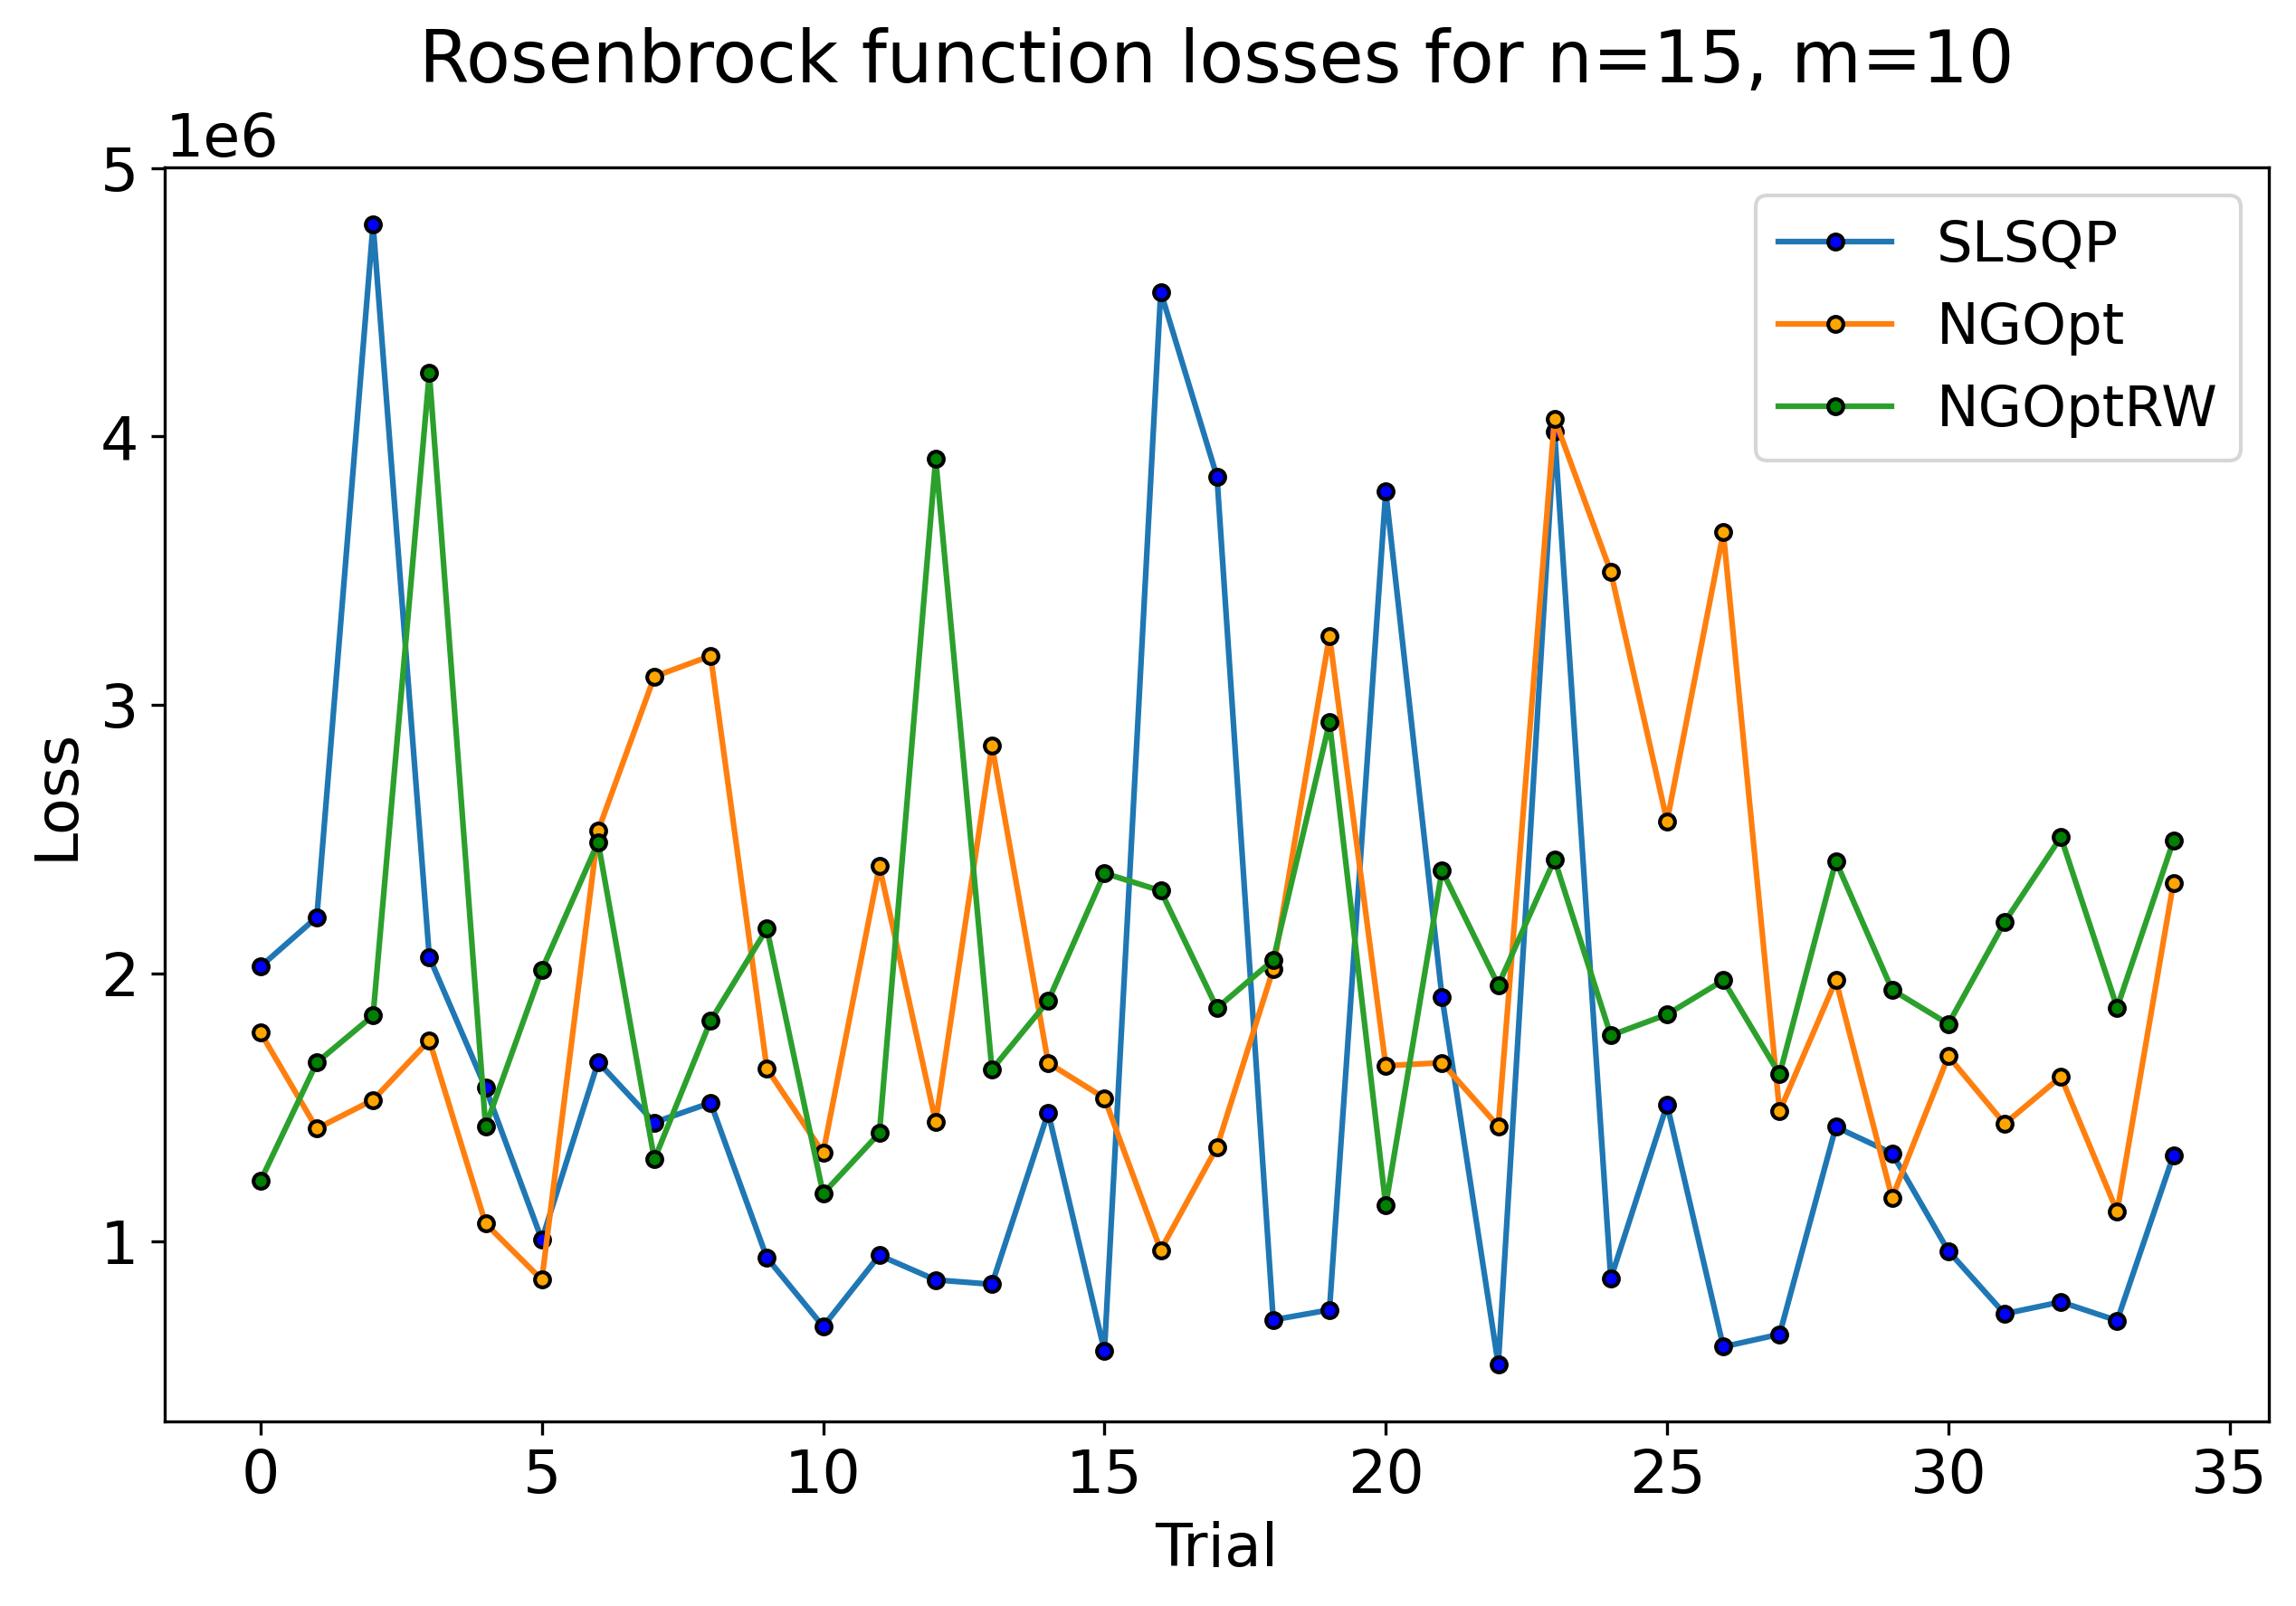

In [6]:
colors = ['blue', 'orange', 'green']

def line_scatter_plot(losses_dict, methods):
    _,ax = plt.subplots(1,1)
    for color, method in zip(colors, methods):
        ax.plot(losses_dict[method],  markerfacecolor=color, label=method)
    ax.legend()
    ax.set_title(f"Rosenbrock function losses for n={n}, m={m}", y=1.05)
    ax.set_xlabel("Trial")
    ax.set_ylabel("Loss")

line_scatter_plot(losses_dict, methods)  


tikzplotlib.save(f"fig_tex/rosenbrock_{n}_{m}_losses.tex")

In [7]:
# import matplotlib as mpl

# plt.close()
# mpl.rcParams.update(mpl.rcParamsDefault)

In [7]:
def box_plot(box_data, methods, title, ylabel):
    df_box = pd.DataFrame({method: box_data[method] for method in methods})
    _,ax = plt.subplots(1,1)
    s_box = sns.boxplot(x="variable", y="value", data=pd.melt(df_box), width=0.5)
    ax.set_title(f"{title} for n={n}, m={m}", y=1.05)
    ax.set_xlabel("Method")
    ax.set_ylabel(ylabel)

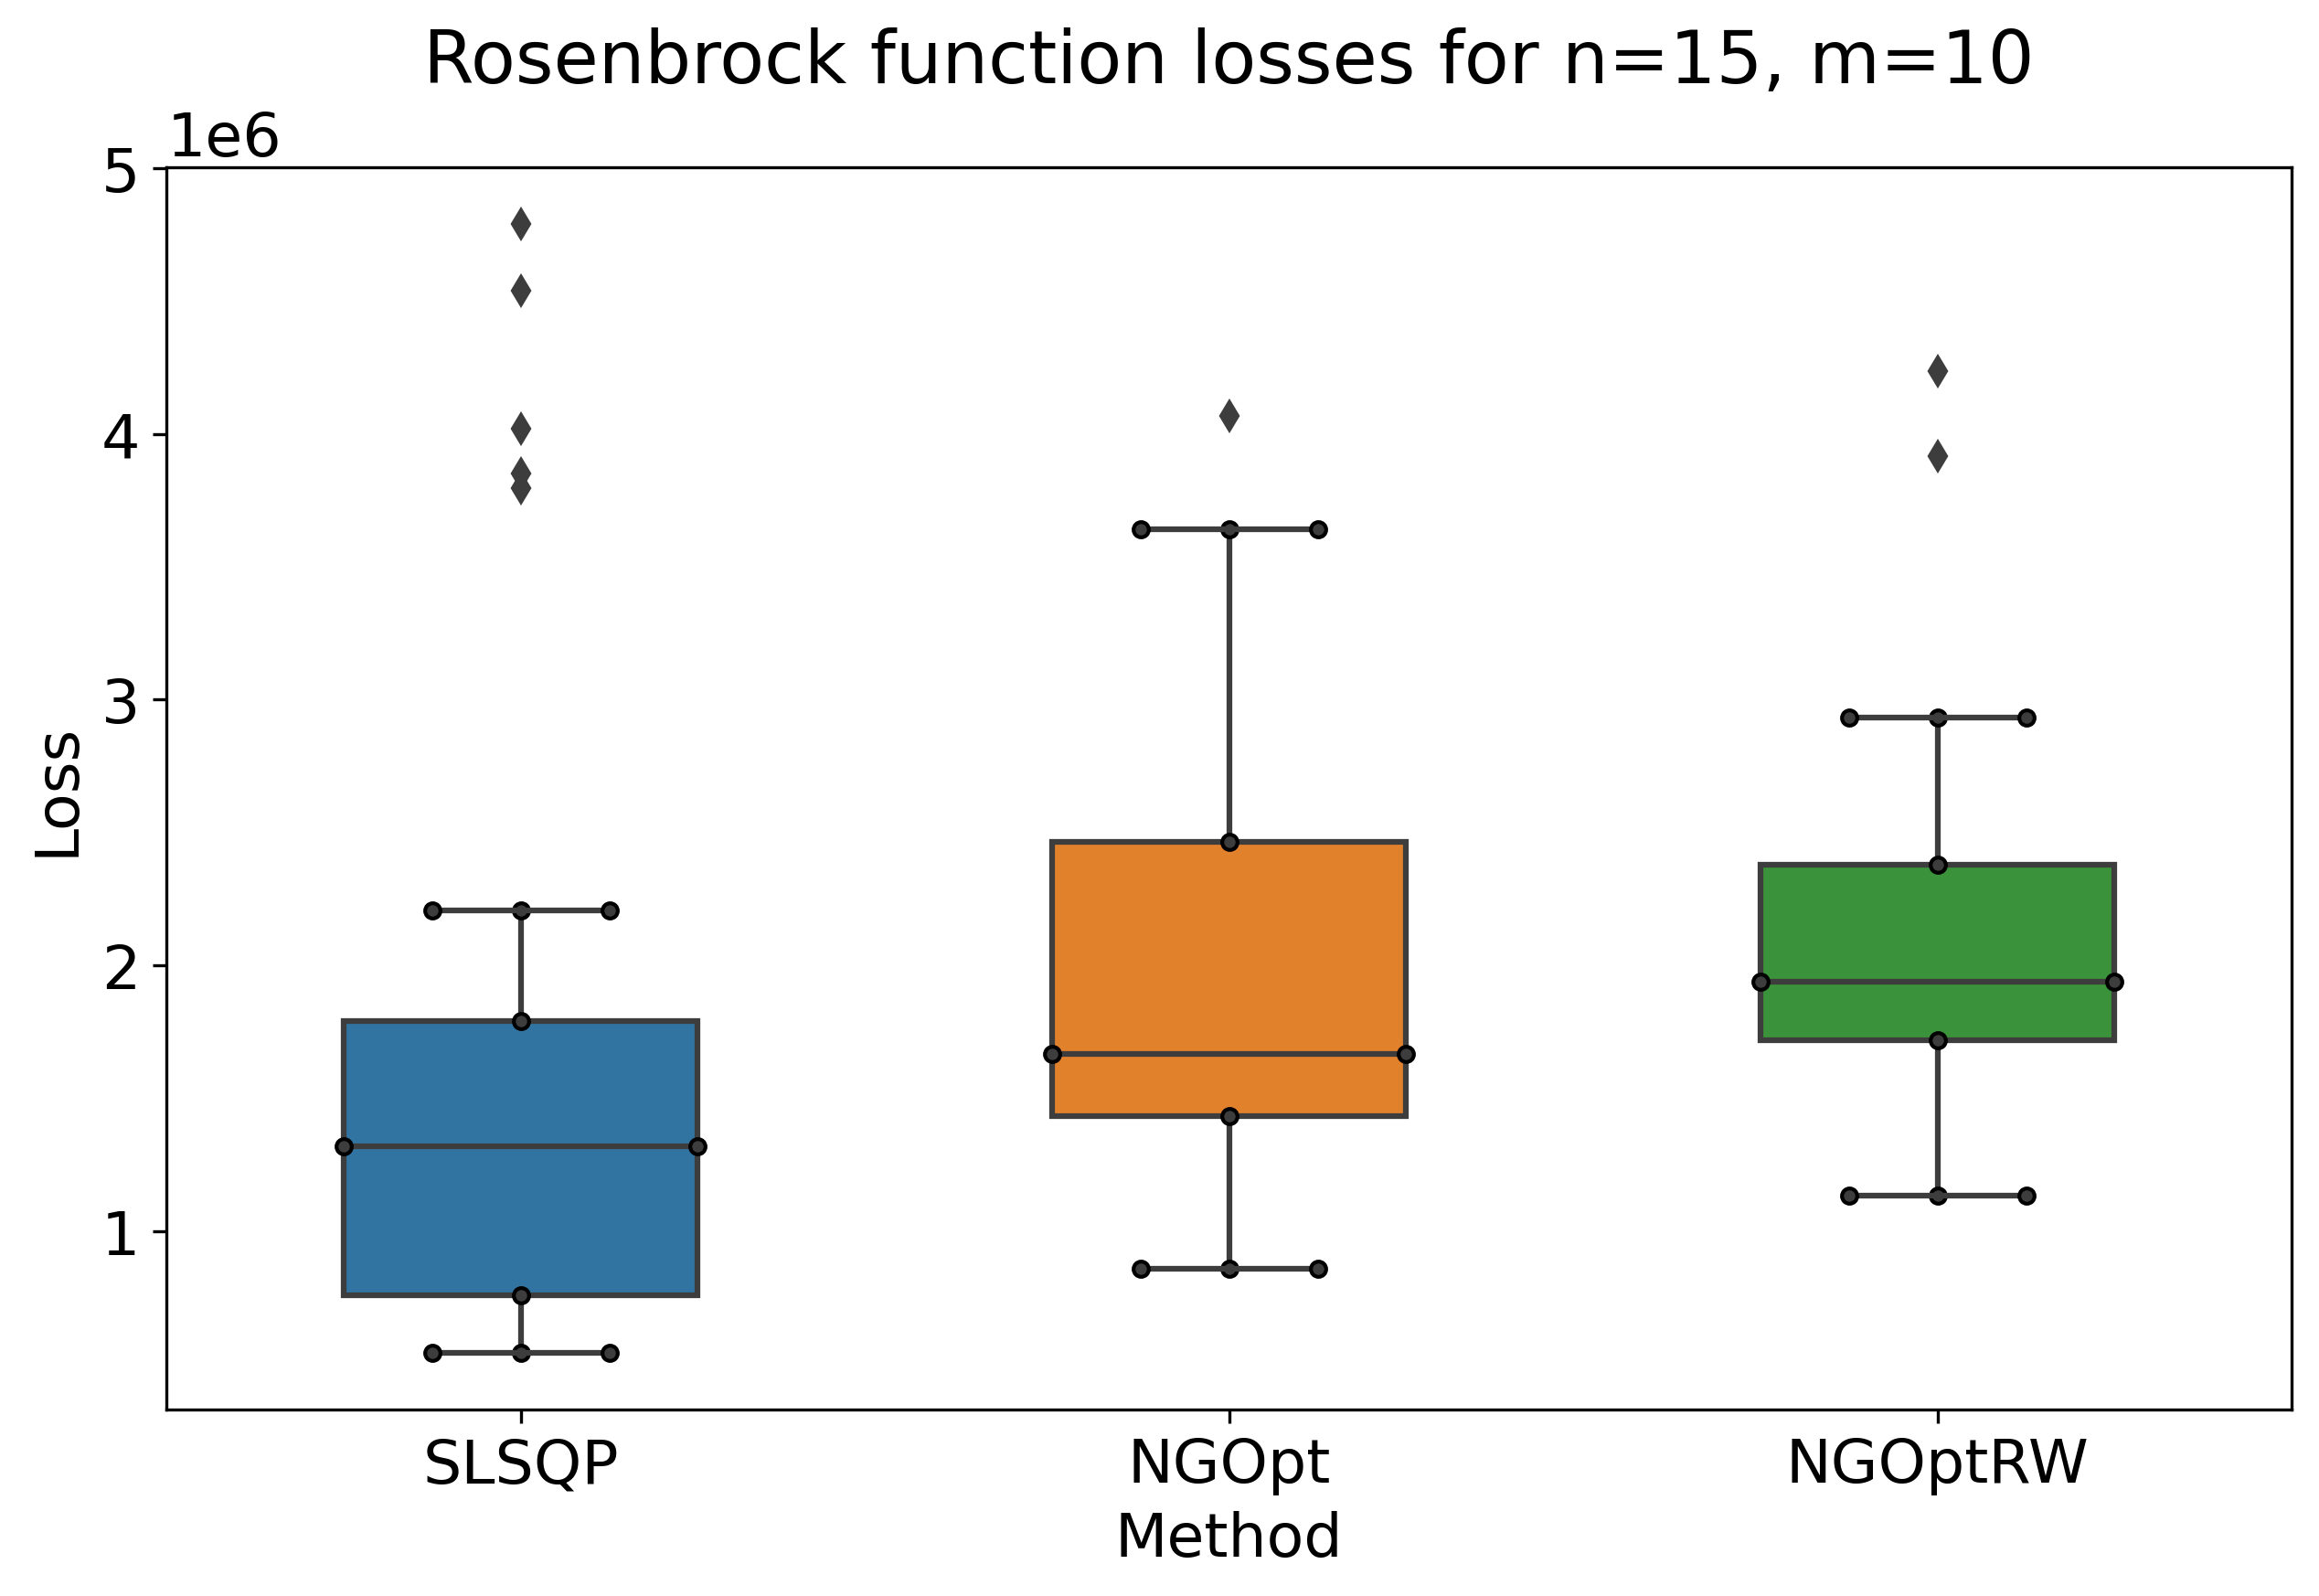

In [42]:
box_plot(losses_dict, methods, "Rosenbrock function losses", "Loss")
tikzplotlib.save(f"fig_tex/rosenbrock_boxplot_{n}_{m}_losses.tex")

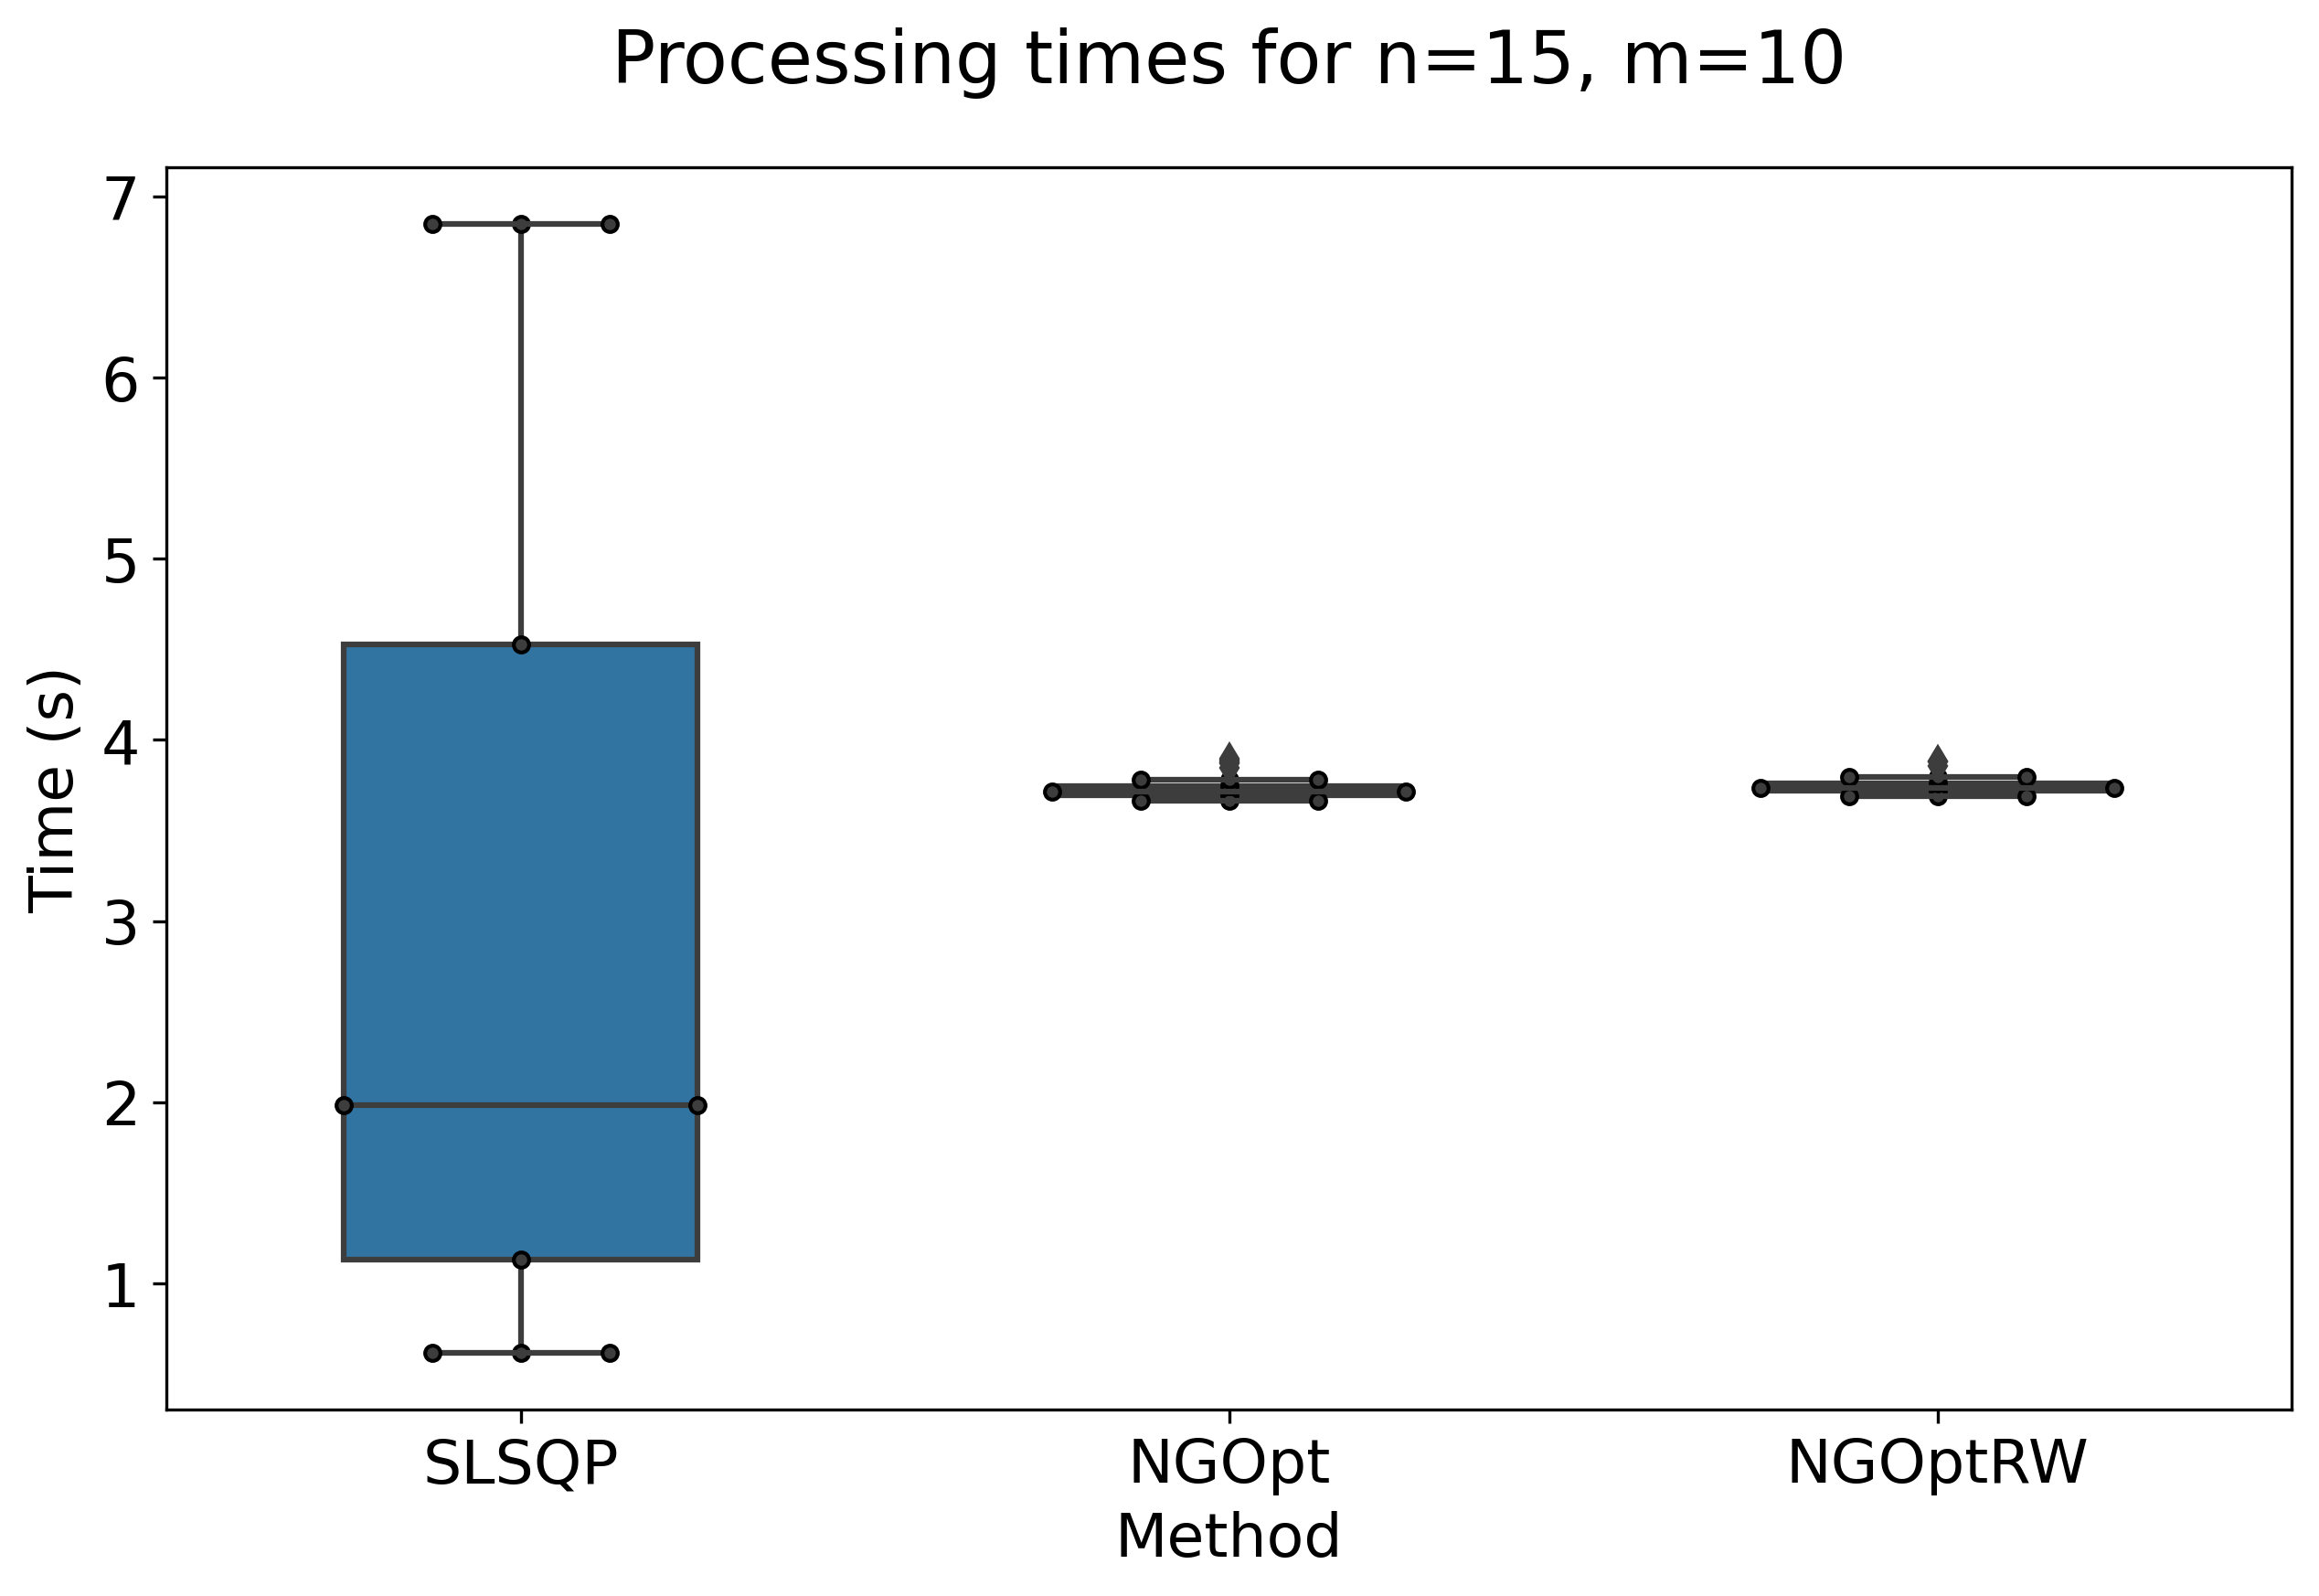

In [43]:
box_plot(times_dict, methods, "Processing times", "Time (s)")
tikzplotlib.save(f"fig_tex/rosenbrock_boxplot_{n}_{m}_times.tex")

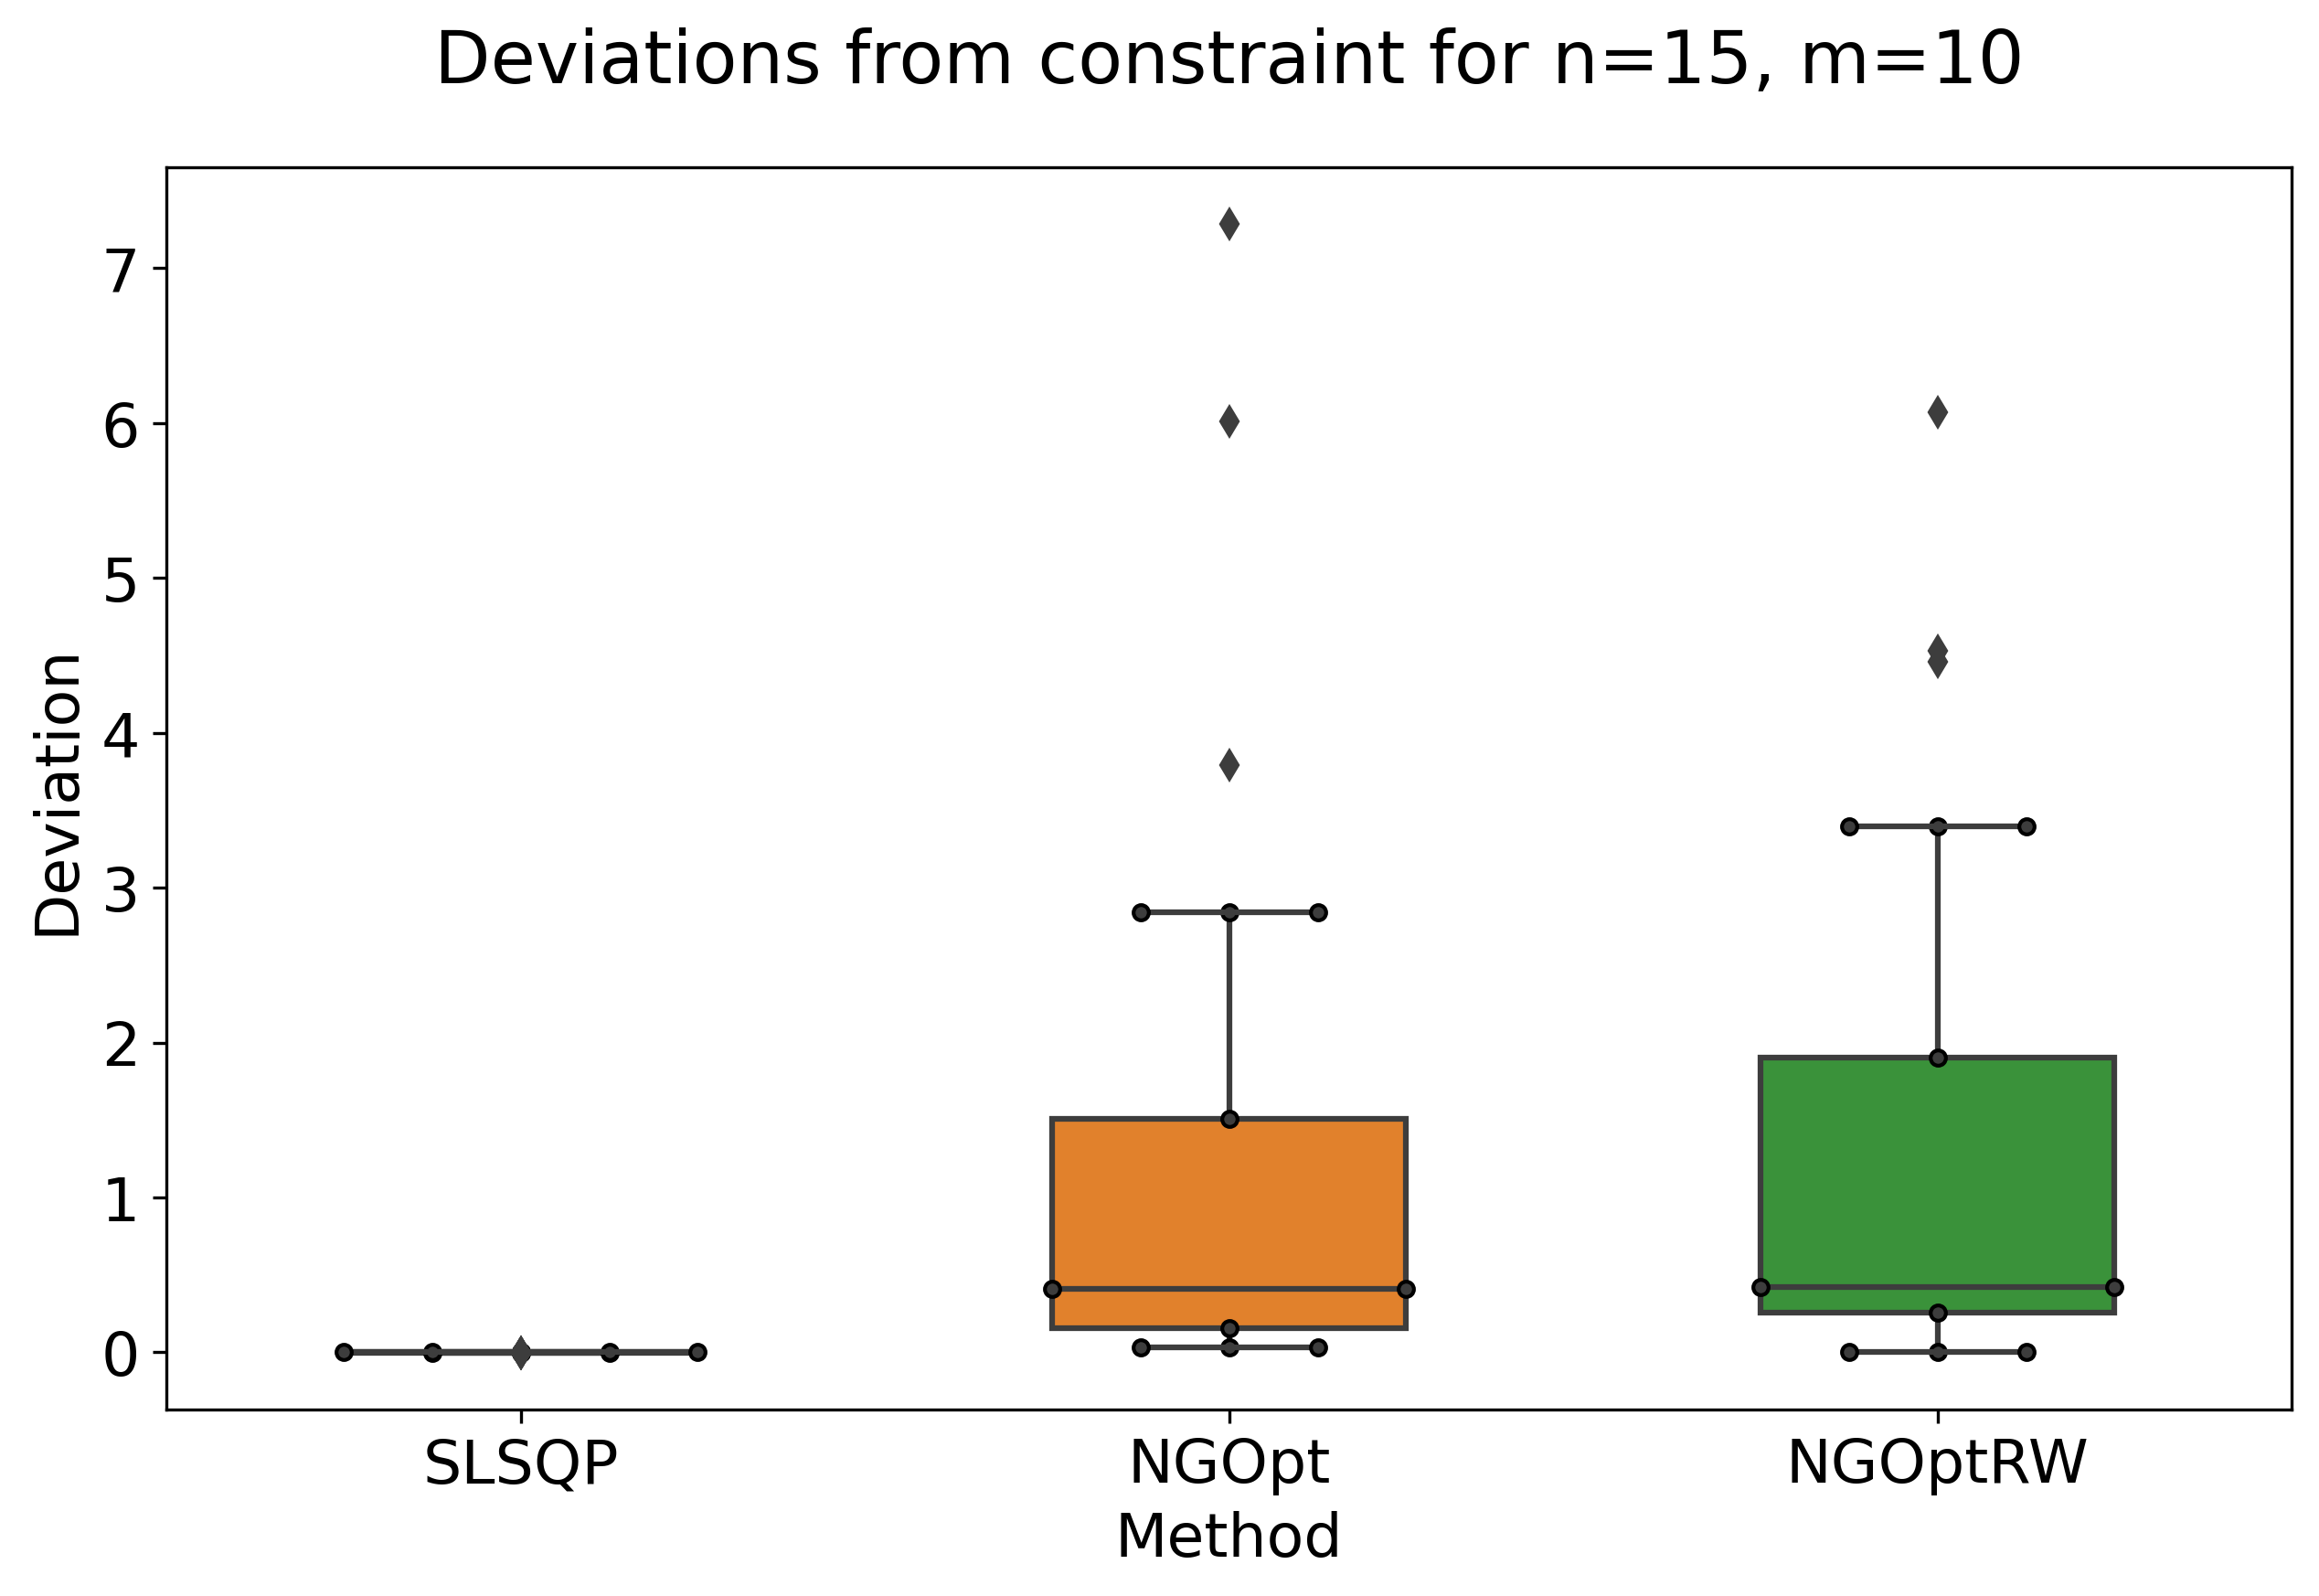

In [44]:
box_plot(deviations_dict, methods, "Deviations from constraint", "Deviation")
tikzplotlib.save(f"fig_tex/rosenbrock_boxplot_{n}_{m}_deviations.tex")

In [8]:
colors = ["C1","C2"]

def box_plot_2(box_data, methods, title, ylabel):
    df_box = pd.DataFrame({method: box_data[method] for method in methods})
    _,ax = plt.subplots(1,1)
    s_box = sns.boxplot(x="variable", y="value", data=pd.melt(df_box), width=0.5, palette=colors)
    ax.set_title(f"{title} for n={n}, m={m}", y=1.05)
    ax.set_xlabel("Method")
    ax.set_ylabel(ylabel)

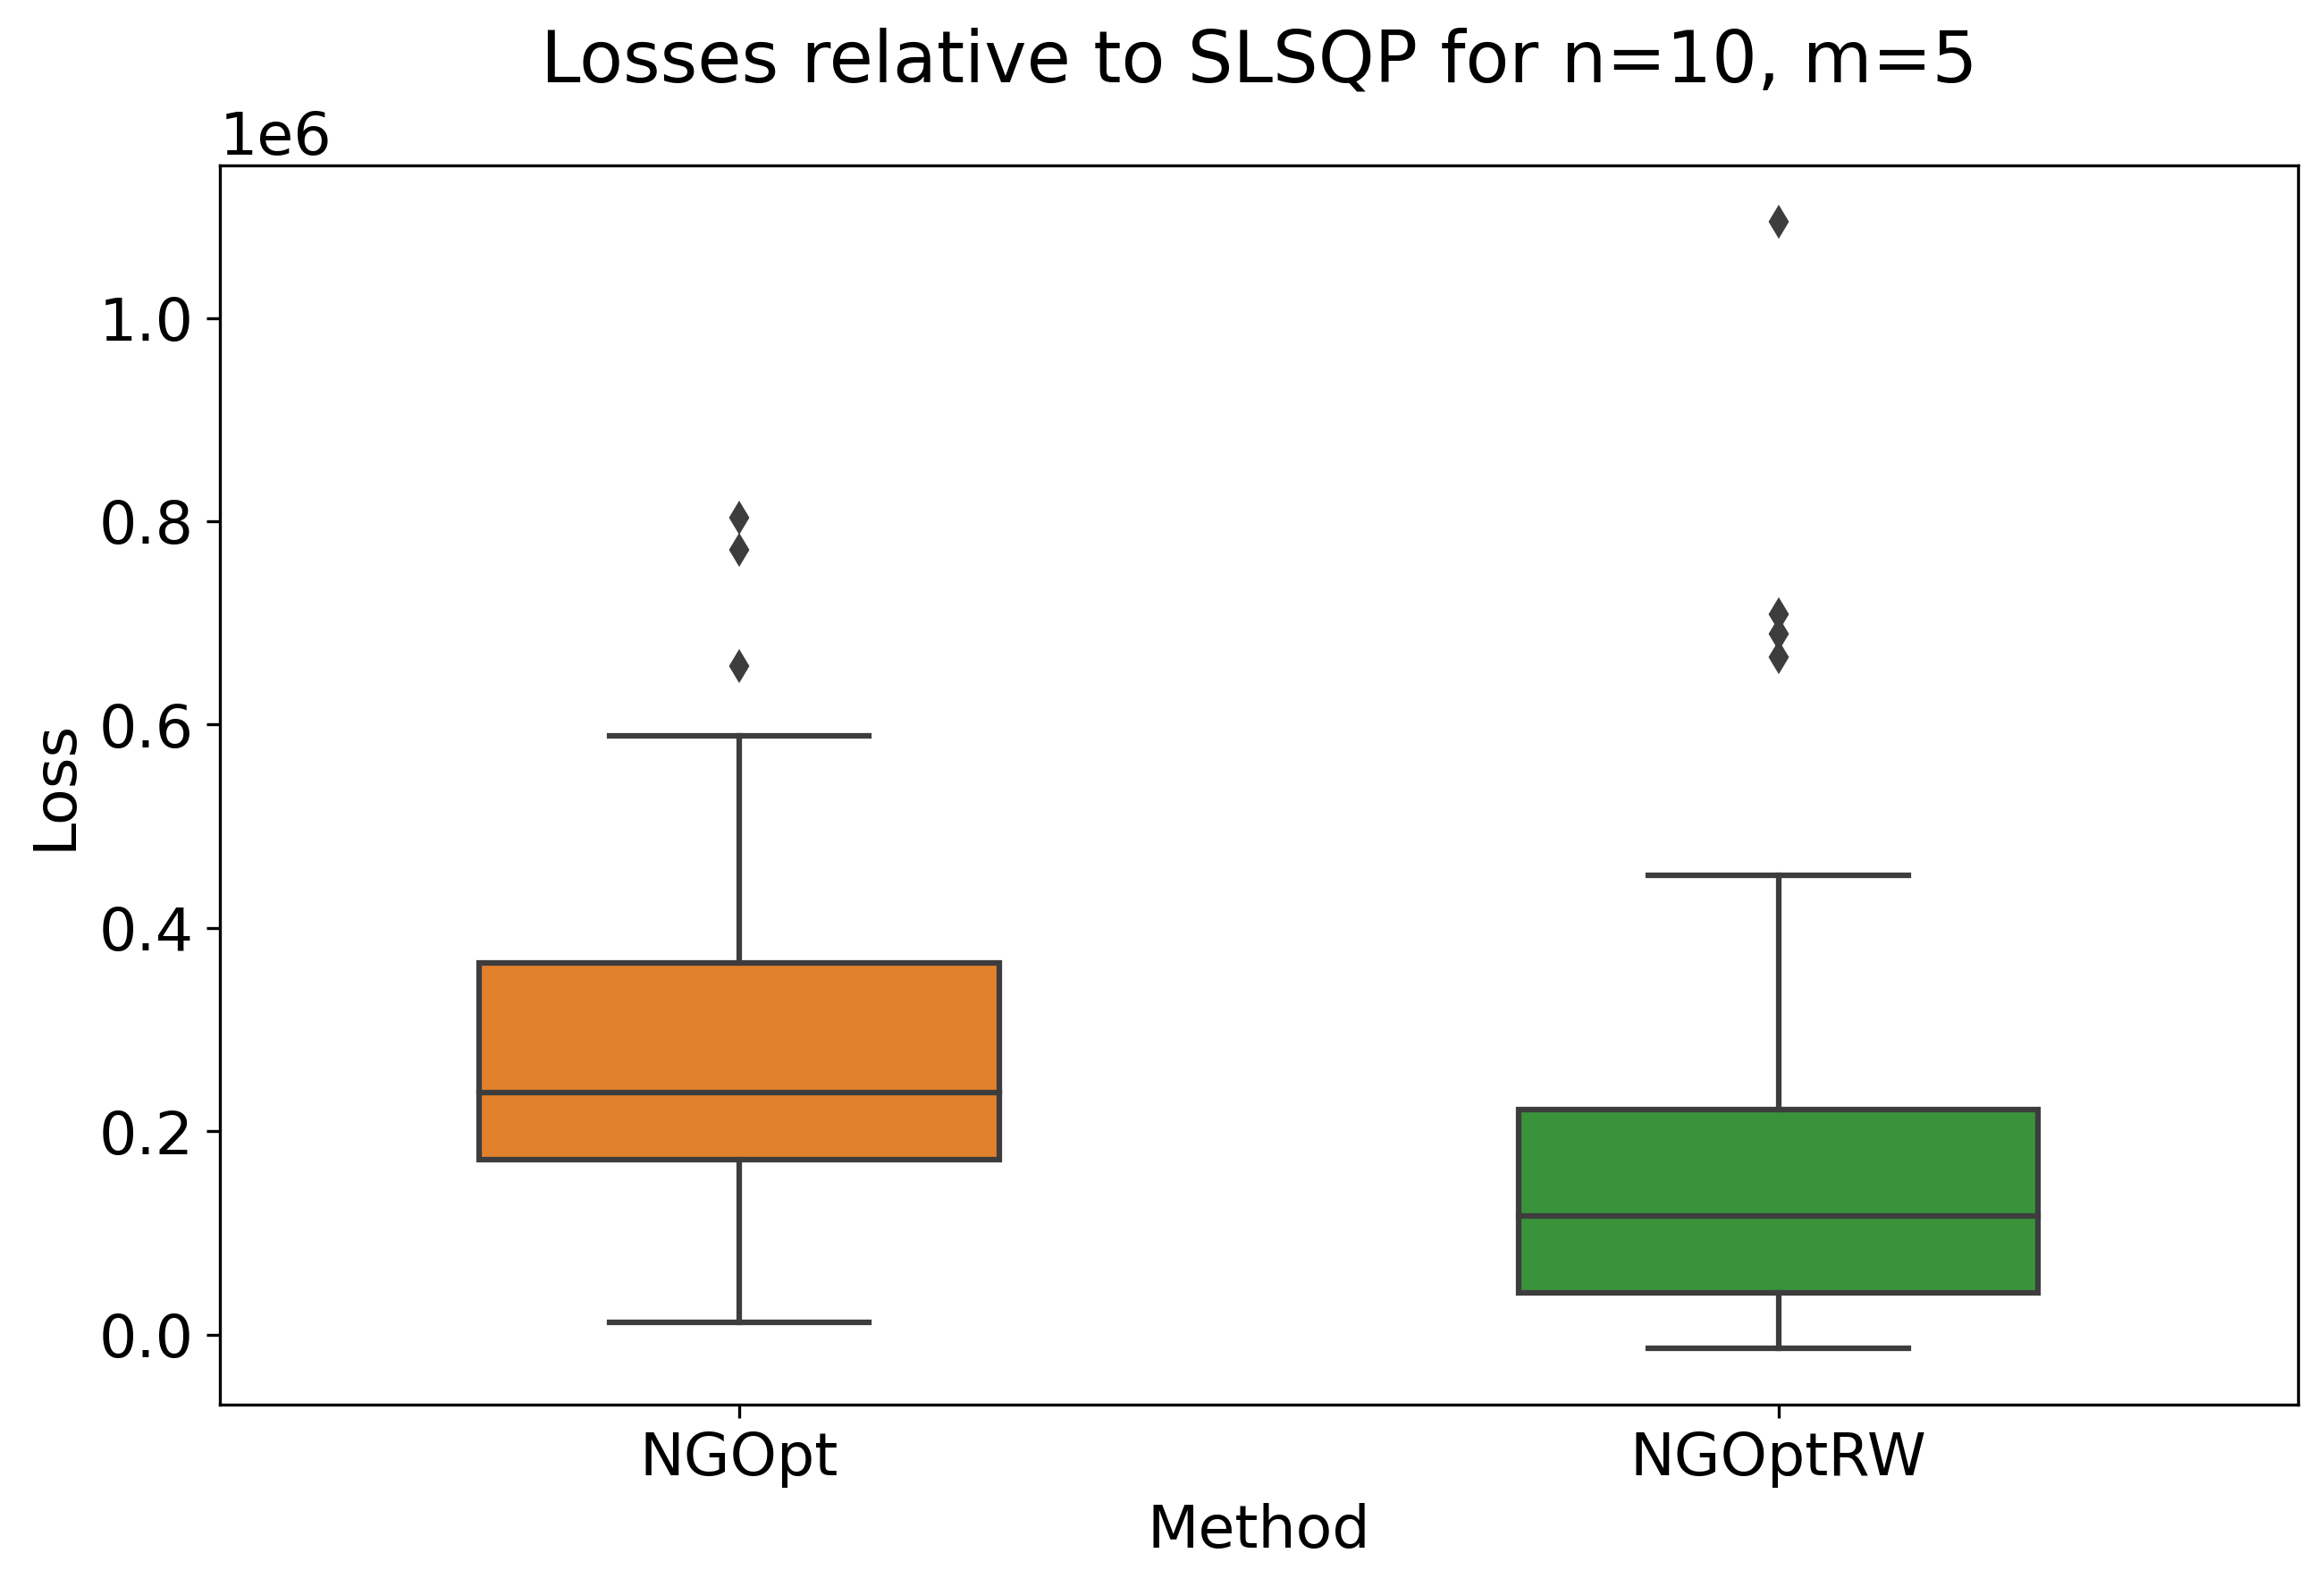

In [18]:
boxplot_data_ng = [np.array(losses_dict[method])-np.array(losses_dict['SLSQP']) for method in ng_methods]
# use a dictionary to map the method names the boxplot_data_ng list
boxplot_data_dict = {method: boxplot_data_ng[i] for i, method in enumerate(ng_methods)}
box_plot_2(boxplot_data_dict, ng_methods, "Losses relative to SLSQP", "Loss")
tikzplotlib.save(f"fig_tex/rosenbrock_boxplot_{n}_{m}_compare_to_ann.tex")

## Previous Methods

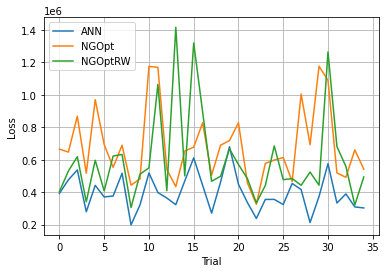

In [28]:
for method in methods:
    plt.plot(losses_dict[method], label=method)
plt.xlabel('Trial')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

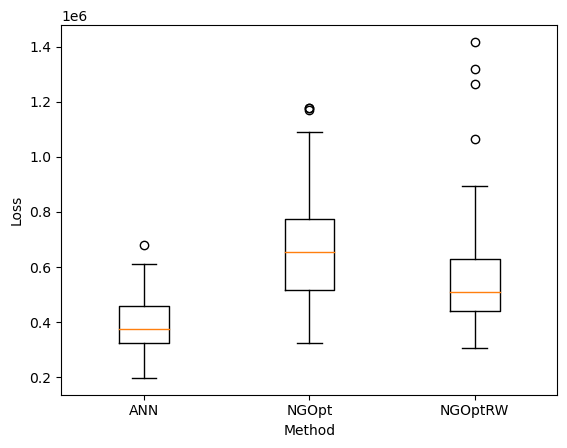

In [60]:
x_indices = [i+1 for i in range(len(methods))]
boxplot_data = [losses_dict[method] for method in methods]
plt.boxplot(boxplot_data)
plt.xticks(x_indices, methods)
plt.xlabel('Method')
plt.ylabel('Loss')
plt.show()

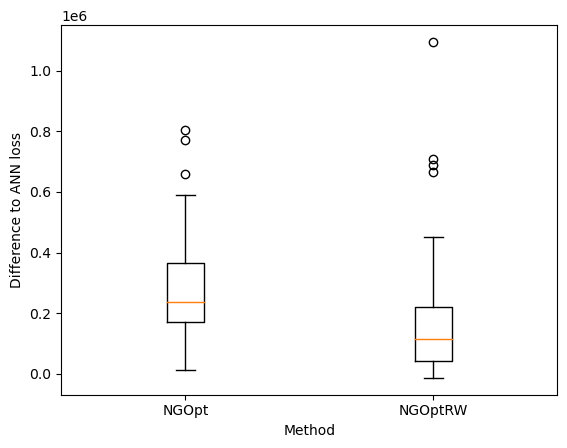

In [61]:
x_indices = [i+1 for i in range(len(ng_methods))]
boxplot_data_ng = [np.array(losses_dict[method])-np.array(losses_dict['ANN']) for method in ng_methods]
plt.boxplot(boxplot_data_ng)
plt.xticks(x_indices, ng_methods)
plt.xlabel('Method')
plt.ylabel('Difference to ANN loss')
plt.show()

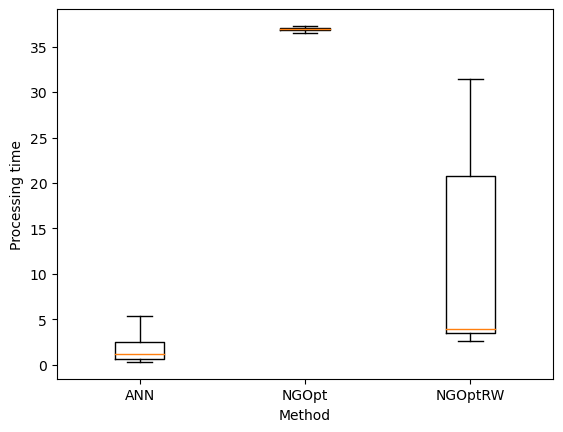

In [62]:
x_indices = [i+1 for i in range(len(methods))]
boxplot_data = [times_dict[method] for method in methods]
plt.boxplot(boxplot_data, showfliers=False)
plt.xticks(x_indices, methods)
plt.xlabel('Method')
plt.ylabel('Processing time')
plt.show()

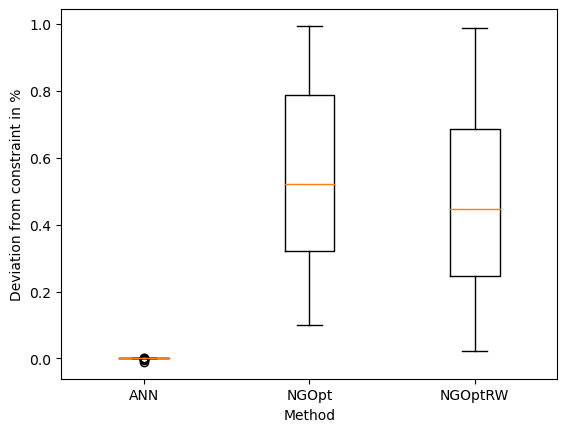

In [63]:
x_indices = [i+1 for i in range(len(methods))]
boxplot_data = [np.array(deviations_dict[method])/(5*m)*100 for method in methods]
plt.boxplot(boxplot_data, showfliers=True)
plt.xticks(x_indices, methods)
plt.xlabel('Method')
plt.ylabel('Deviation from constraint in %')
plt.show()

## Statistical evaluation

In [15]:
print("Two-sided t-test for equality of means between SLSQP and...")
for method in ng_methods:
    print(f"{method}: {stats.ttest_rel(losses_dict['SLSQP'], losses_dict[method]).pvalue}")

Two-sided t-test for equality of means between SLSQP and...
NGOpt: 0.13645758591924473
NGOptRW: 0.051566546265231876


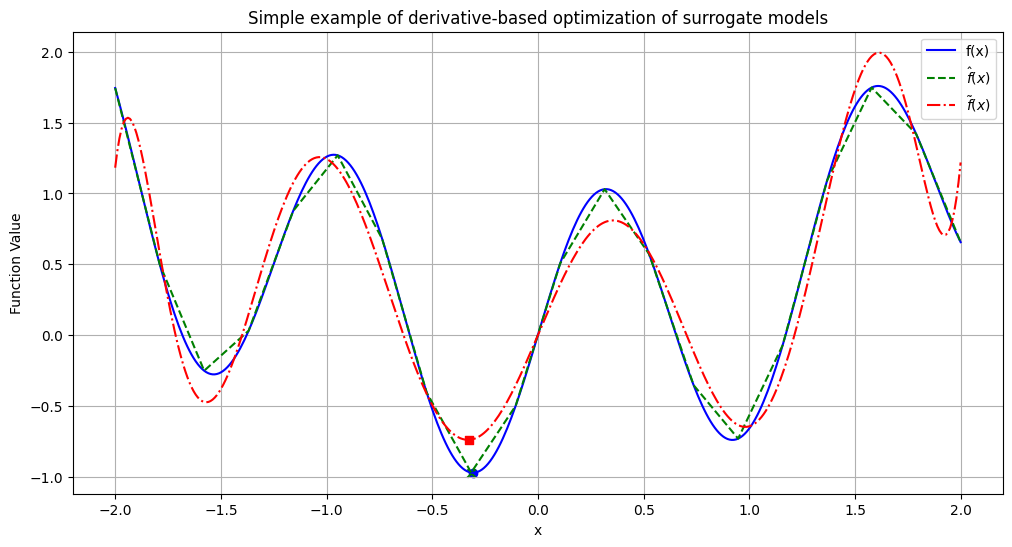

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define the functions
x = np.linspace(-2, 2, 400)
f = np.sin(5*x) + 0.3*x**2

# Piecewise approximation of f
x_hat = np.linspace(-2, 2, 20)
f_hat = np.sin(5*x_hat) + 0.3*x_hat**2
f_hat_interpolated = np.interp(x, x_hat, f_hat)

# Smoothed version of f_hat using polynomial fitting
coeff = np.polyfit(x, f_hat_interpolated, 6)
f_tilde = np.polyval(coeff, x)

# Find the minima
min_f = np.min(f)
min_f_hat = np.min(f_hat_interpolated)
min_f_tilde = np.min(f_tilde)

# Using a high-degree polynomial to fit f directly
coeff_direct_fit = np.polyfit(x, f, 10)
f_tilde_direct_fit = np.polyval(coeff_direct_fit, x)

# Find the minima for the direct f_tilde
min_f_tilde_direct_fit = np.min(f_tilde_direct_fit)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x, f, label='f(x)', color='blue')
plt.plot(x, f_hat_interpolated, label=r'$\hat{f}(x)$', linestyle='--', color='green')
plt.plot(x, f_tilde_direct_fit, label=r'$\tilde{f}(x)$', linestyle='-.', color='red')
plt.scatter(x[np.argmin(f)], min_f, color='blue', marker='o')
plt.scatter(x[np.argmin(f_hat_interpolated)], min_f_hat, color='green', marker='x')
plt.scatter(x[np.argmin(f_tilde_direct_fit)], min_f_tilde_direct_fit, color='red', marker='s')
plt.xlabel('x')
plt.ylabel('Function Value')
plt.title('Simple example of derivative-based optimization of surrogate models')
plt.legend()
plt.grid(True)
plt.show()
